# Problem statement

- In today’s digital ecosystem, audiences express opinions on movies through online reviews, blogs, and social platforms. These reviews contain valuable insights reflecting public sentiments, but their unstructured textual nature makes manual analysis time-consuming and subjective. Sentiment analysis offers a way to automatically interpret and classify these opinions to determine whether a review conveys a positive or negative attitude toward a film.

- The problem addressed in this study is to develop a machine learning pipeline capable of automatically classifying the sentiment polarity (positive or negative) of movie reviews using Natural Language Processing (NLP). The system should process raw textual inputs, clean and normalize the text, extract meaningful features using TF-IDF or embeddings, and train a robust model such as Logistic Regression or another classifier to predict sentiment with high precision and recall.

- Furthermore, this project extends beyond sentiment detection by including a translation module, enabling the system to handle multilingual movie reviews. Non-English reviews are translated to English before analysis, ensuring that sentiment classification can be performed across diverse linguistic audiences. This combined framework supports both local and global movie producers by helping them assess audience perceptions across languages.

## Objectives

- To preprocess and clean textual movie reviews using tokenization, lemmatization, and stopword removal.

- To extract linguistic and statistical features through TF-IDF vectorization for model training.

- To train and evaluate classification models (e.g., Logistic Regression, Naïve Bayes, or deep learning variants) to detect sentiment polarity.

- To integrate language translation support for multilingual review analysis.

- To deploy the trained model into a Flask-based web application that provides real-time sentiment prediction for user-submitted texts.

## Importing all the dependencies

In [1]:
import warnings
import re
import string
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [2]:
%%time
df = pd.read_csv("IMDB-Dataset.csv", encoding = "latin-1")
df.head()

CPU times: total: 14.2 s
Wall time: 15 s


Ratings                                            Reviews          Movies  \
0      1.0  *Disclaimer: I only watched this movie as a co...  Disaster Movie   
1      1.0  I am writing this in hopes that this gets put ...  Disaster Movie   
2      1.0  Really, I could write a scathing review of thi...  Disaster Movie   
3      1.0  If you saw the other previous spoof movies by ...  Disaster Movie   
4      1.0  This movie I saw a day early for free and I st...  Disaster Movie   

                                            Resenhas  
0  * IsenÃ§Ã£o de responsabilidade: eu sÃ³ assist...  
1  Estou escrevendo isso na esperanÃ§a de que iss...  
2  Realmente, eu poderia escrever uma crÃ­tica co...  
3  Se vocÃª viu os outros filmes falsificados ant...  
4  Este filme eu vi um dia cedo de graÃ§a e ainda...

## 1. Data cleaning and Preprocessing

In [3]:
## Customize stopword as per data
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
new_stopwords = ["movie", "one", "film", "would", "shall", "could", "might"]
stop_words.extend(new_stopwords)
stop_words.remove("not")
stop_words = set(stop_words)

In [4]:
"""-------------------Data Cleaning and Preprocessing pipeline--------------------------------"""
import re
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

## Remove special characters (non-alphanumeric and spaces)
def remove_special_character(content):
    # Remove characters except alphabets, digits, and spaces
    return re.sub(r"[^a-zA-Z0-9\s]", " ", content)

## Remove URLs
def remove_url(content):
    # Remove common URL patterns starting with http or www
    return re.sub(r"http\S+|www\S+|https\S+", " ", content, flags=re.IGNORECASE)

## Remove stopwords from text
def remove_stopwords(content):
    words = content.split()
    clean_words = [w.lower() for w in words if w.lower() not in stop_words and w.isalpha()]
    return " ".join(clean_words)

## Expansion of English contractions (examples fixed with common expansions)
def contractions_expansion(content):
    contractions_dict = {
        "won't": "will not",
        "can't": "cannot",
        "don't": "do not",
        "shouldn't": "should not",
        "needn't": "need not",
        "hasn't": "has not",
        "haven't": "have not",
        "weren't": "were not",
        "mightn't": "might not",
        "didn't": "did not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, expansion in contractions_dict.items():
        content = re.sub(contraction, expansion, content, flags=re.IGNORECASE)
    return content

### Data Preprocessing: chaining steps
def data_cleaning(content):
    content = remove_special_character(content)
    content = remove_url(content)
    content = contractions_expansion(content)
    content = remove_stopwords(content)
    return content

In [5]:
# Initialize stopwords set
stop_words = set(stopwords.words("english"))
"""-------------------Data Cleaning and Preprocessing pipeline--------------------------------"""

# Remove special characters (everything but letters, numbers, spaces)
def remove_special_character(content):
    return re.sub(r"[^a-zA-Z0-9\s]", " ", content)

# Remove URLs from text (http, https, www)
def remove_url(content):
    return re.sub(r"http\S+|www\.\S+", " ", content)

# Remove stopwords and keep only alphabetic tokens
def remove_stopwords(content):
    clean_data = []
    for word in content.split():
        word_lower = word.strip().lower()
        if word_lower not in stop_words and word_lower.isalpha():
            clean_data.append(word_lower)
    return " ".join(clean_data)

# Expansion of English contractions
def contractions_expansion(content):
    contractions_dict = {
        "won't": "will not",
        "can't": "can not",
        "don't": "do not",
        "shouldn't": "should not",
        "needn't": "need not",
        "hasn't": "has not",
        "haven't": "have not",
        "weren't": "were not",
        "mightn't": "might not",
        "didn't": "did not",
        "n't": " not",
        "'re": " are",
        "'s": " is",
        "'d": " would",
        "'ll": " will",
        "'t": " not",
        "'ve": " have",
        "'m": " am"
    }
    for contraction, expansion in contractions_dict.items():
        content = re.sub(re.escape(contraction), expansion, content)
    return content

# Data Preprocessing pipeline
def data_cleaning(content):
    content = remove_special_character(content)
    content = remove_url(content)
    content = contractions_expansion(content)
    content = remove_stopwords(content)
    return content

In [6]:
%%time 
## Data Cleaning
df['Reviews']= df['Reviews'].apply(data_cleaning)
df['Reviews'].head(5)

CPU times: total: 1min 15s
Wall time: 1min 19s


0    disclaimer watched movie conditional agreement...
1    writing hopes gets put previous review film an...
2    really could write scathing review turd sandwi...
3    saw previous spoof movies two horrible gentlem...
4    movie saw day early free still feel like got r...
Name: Reviews, dtype: object

## Data Overview

In [7]:
## Checking for missing value
df.isnull().sum()

Ratings      0
Reviews      0
Movies      25
Resenhas     0
dtype: int64

In [8]:
df['Ratings'].describe()

count    150000.000000
mean          5.500000
std           2.872291
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: Ratings, dtype: float64

In [9]:
print("Unique review: %s" % df.Reviews.nunique())
print("Unique movie names: %s" % df.Movies.nunique())
print("No of retings: %s" % df.Ratings.count())

Unique review: 149752
Unique movie names: 14206
No of retings: 150000


# Exploratory Data Analysis

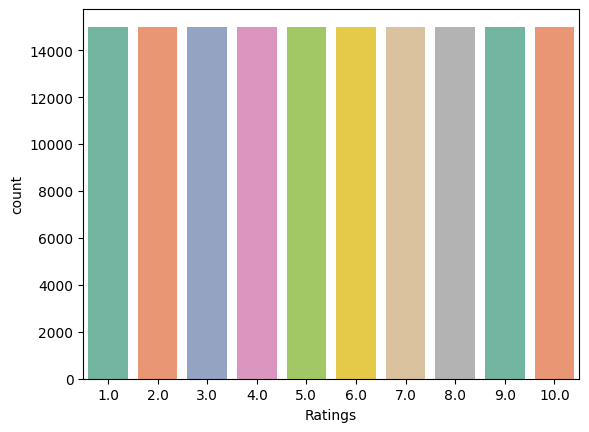

Ratings
1.0     15000
2.0     15000
4.0     15000
3.0     15000
5.0     15000
6.0     15000
8.0     15000
7.0     15000
10.0    15000
9.0     15000
Name: count, dtype: int64


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: using a seaborn predefined palette 'Set2' for multicolored bars
sns.countplot(x=df["Ratings"], palette="Set2")

plt.show()

print(df["Ratings"].value_counts())

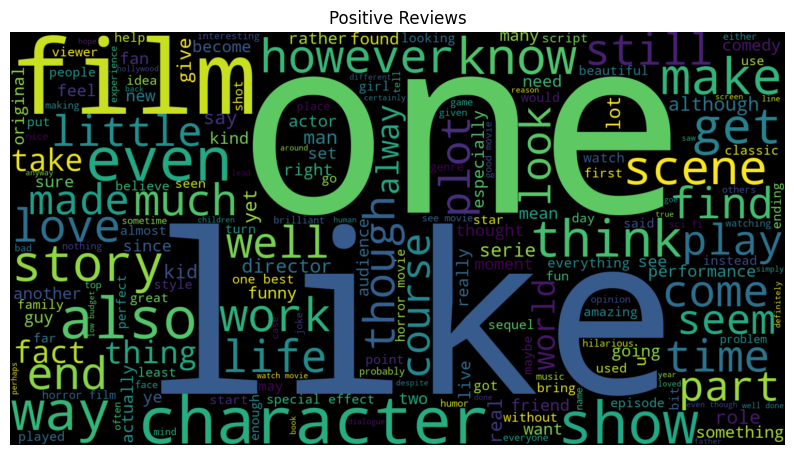

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all positive reviews into a single string with proper closing parentheses
sentences = df["Reviews"]
pos = " ".join(map(str, sentences[df["Ratings"] >= 7]))


# Generate word cloud with correct class name and parameters
pos_wordcloud = WordCloud(
    width=1500,
    height=800,
    background_color="black",
    stopwords=stop_words,
    min_font_size=15
).generate(pos)

# Plot the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.title("Positive Reviews")
plt.axis("off")
plt.show()

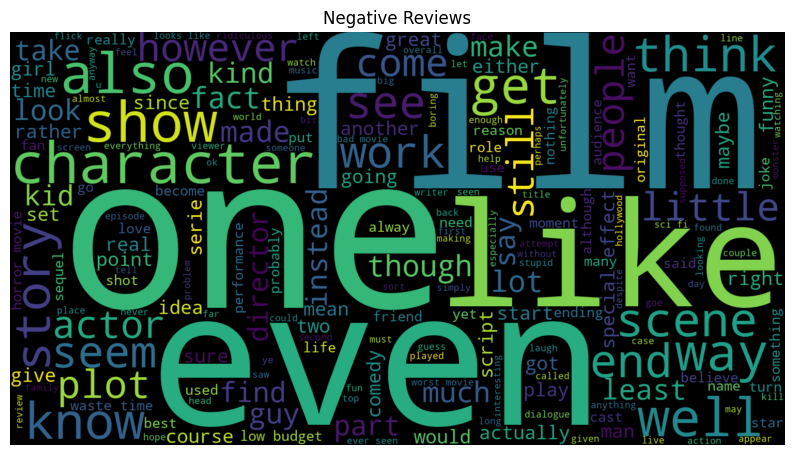

In [12]:

# Combine all negative reviews into a single string with proper parentheses
sentences = df["Reviews"]
neg = " ".join(map(str, sentences[df["Ratings"] <= 4]))

# Generate word cloud for negative reviews
neg_wordcloud = WordCloud(
    width=1500,
    height=800,
    background_color="black",
    stopwords=stop_words,  # Ensure stop_words is defined
    min_font_size=15
).generate(neg)

# Plot the word cloud for negative reviews
plt.figure(figsize=(10, 10))
plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.title("Negative Reviews")
plt.axis("off")
plt.show()

## Basic Statistics of Review data 

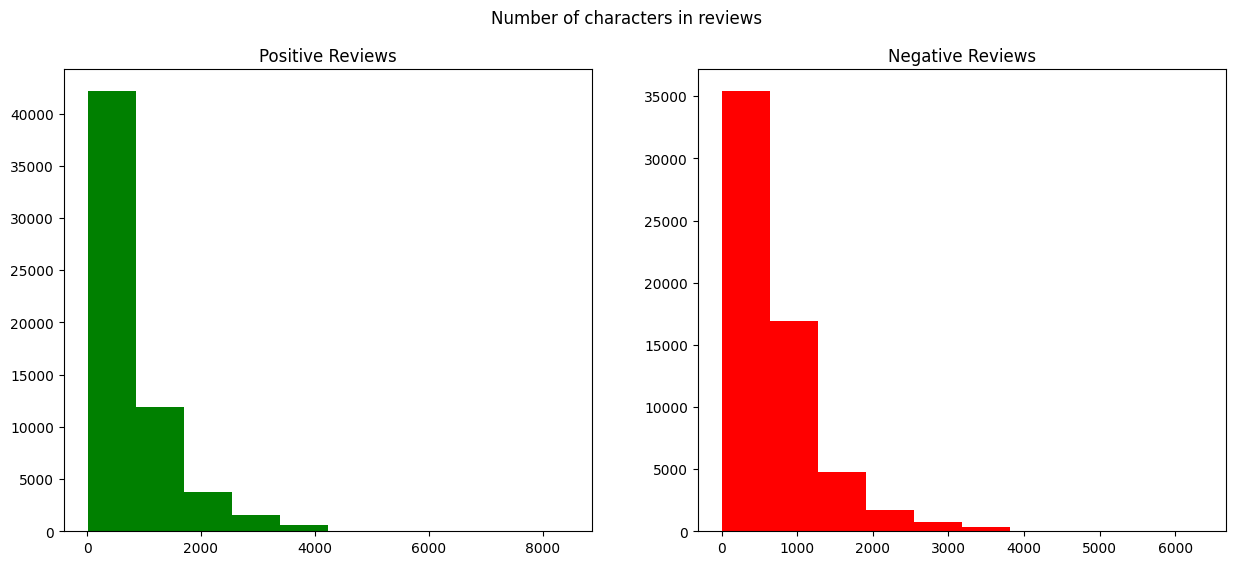

In [13]:
#Visualization of the number of characters in reviews
import matplotlib.pyplot as plt

# Correct way to create a figure with 2 subplots side by side
fig, (pos_ax, neg_ax) = plt.subplots(1, 2, figsize=(15, 6))

# Correct filtering applied first, then accessing column and length:
len_pos_review = df[df["Ratings"] >= 7]["Reviews"].str.len()
pos_ax.hist(len_pos_review, color="green")
pos_ax.set_title("Positive Reviews")

len_neg_review = df[df["Ratings"] <= 4]["Reviews"].str.len()
neg_ax.hist(len_neg_review, color="red")
neg_ax.set_title("Negative Reviews")

fig.suptitle("Number of characters in reviews")
plt.show()

## Visualize the average of words in reviews

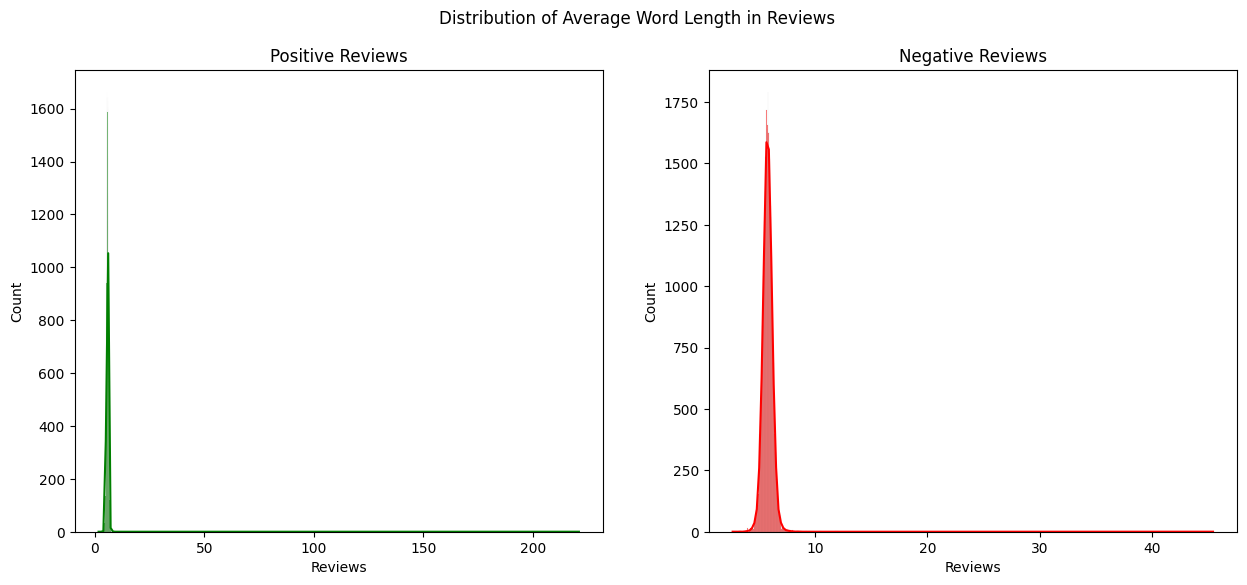

In [14]:
 
fig, (pos_ax, neg_ax) = plt.subplots(1, 2, figsize=(15, 6))

# Calculate average word length in positive reviews
len_pos_review = df[df["Ratings"] >= 7]["Reviews"].str.split().apply(lambda x: np.mean([len(word) for word in x]))
sns.histplot(len_pos_review, ax=pos_ax, color="green", kde=True)
pos_ax.set_title("Positive Reviews")

# Calculate average word length in negative reviews
len_neg_review = df[df["Ratings"] <= 4]["Reviews"].str.split().apply(lambda x: np.mean([len(word) for word in x]))
sns.histplot(len_neg_review, ax=neg_ax, color="red", kde=True)
neg_ax.set_title("Negative Reviews")

fig.suptitle("Distribution of Average Word Length in Reviews")
plt.show()

- According to the data , the Average word length of the reviews is higher for negative reviews when compared to the positive reviews.

In [15]:
## Get important feature by using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Function to get top n n-grams
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
# Get top 20 unigrams for positive reviews
most_common_uni = get_top_text_ngrams(df["Reviews"][df["Ratings"] >= 7], 20, 1)
most_common_uni = dict(most_common_uni)

# Create DataFrame for plotting
temp = pd.DataFrame(columns = ["common_words", "count"])
temp["common_words"]= list(most_common_uni.keys())
temp["count"]= list(most_common_uni.values())
 
## Plot
fig = px.bar(temp, x="count",y="common_words",title="Common Words in Positive Reviews",orientation="h",width=700,height=700,color="common_words")
fig.show()

In [17]:
## For Bigrams
most_common_uni = get_top_text_ngrams(df["Reviews"][df["Ratings"] >= 7], 20, 2)
most_common_uni = dict(most_common_uni)

# Create DataFrame for plotting
temp = pd.DataFrame(columns = ["common_words", "count"])
temp["common_words"]= list(most_common_uni.keys())
temp["count"]= list(most_common_uni.values())
 
## Plot
fig = px.bar(temp, x="count",y="common_words",title="Common Bigram Words in Positive Reviews",orientation="h",width=700,height=700,color="common_words")
fig.show()

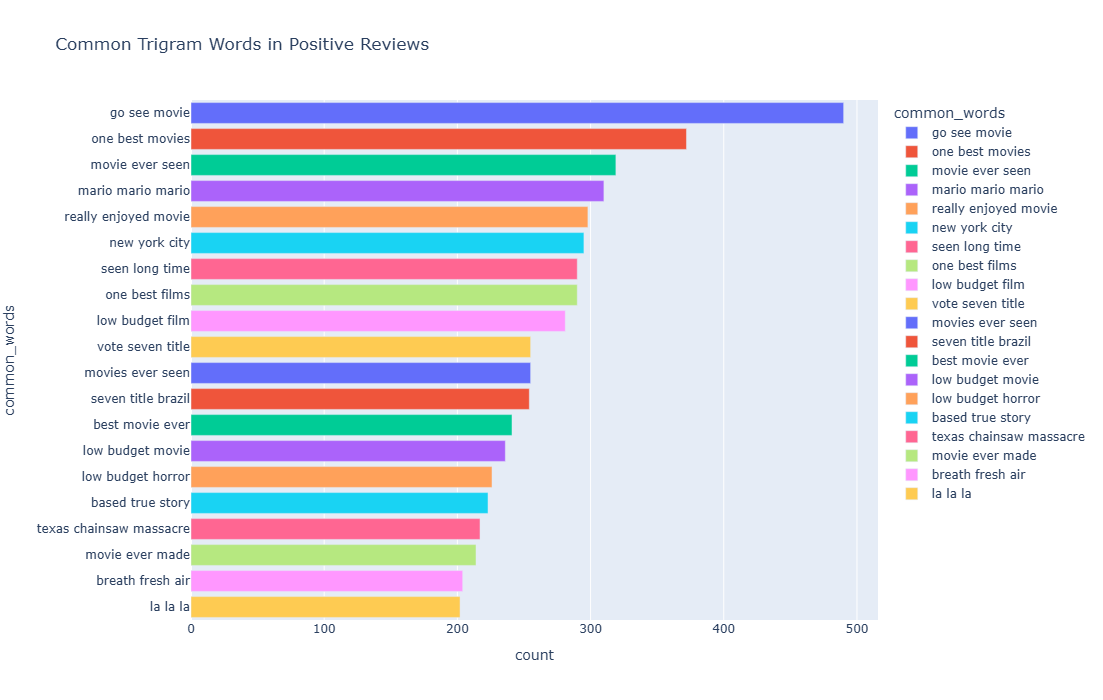

In [18]:
# For trigram 
most_common_uni = get_top_text_ngrams(df["Reviews"][df["Ratings"] >= 7], 20, 3)
most_common_uni = dict(most_common_uni)

# Create DataFrame for plotting
temp = pd.DataFrame(columns = ["common_words", "count"])
temp["common_words"]= list(most_common_uni.keys())
temp["count"]= list(most_common_uni.values())
 
## Plot
fig = px.bar(temp, x="count",y="common_words",title="Common Trigram Words in Positive Reviews",orientation="h",width=700,height=700,color="common_words")
fig.show()

In [19]:
pd.options.display.max_colwidth = 1000
df[["Reviews","Ratings","Movies"]][(df['Ratings']>=7)&(df['Reviews'].str.contains("not like| not want| not big fan"))].head(30)

Reviews  \
99732                                                        exciting see premiere episode show week abc let hope start something big introduced nyc medical examiner named henry morgan lab assistant best friend police detective lot questions mention elusive villain clear promise seasons intrigue show like high concept always problematic fans many fans milder reality based sci fi concepts risk diving show carries possibility grind halt dozen episodes like awake story ideas end twisted kind poorly written gordian knot like alphas forging ahead faith talented players track record main show runners brad anderson matthew miller saw monday premier forever well within best expect duo gonna great personally hope lot people feel way well addendum following episode two outstanding premiere aired monday episode two amazingly tedious plot borrowed episodes bones still expect show coming weeks wow let bring game   
149489  let try understand miracle witnessed director wes anderson years old experienced first love summer camp immediately rushed camera tell us pen pals story slightly embellished story follows perfect scenarios would draw night beds age tiny details sense adventure freshness youth someone years old real life could movie beyond drawback miracle viewer jump back kind idealized feelings early teens leaves quite melancholy leave cinema could people connect movie see adorable cute nothing suppose people feel connected notably movie straight point attitude technique story telling story read force fed dramatic music whatnot like one characters reads bedtime stories others might complain lack character development big names film norton willis murray mcdormand less gets detailed screen time others suppose wanted kids see hints issues adults facing understand fully remember movie shot year old wes anderson   

        Ratings            Movies  
99732       7.0           Forever  
149489     10.0  Moonrise Kingdom

In [20]:
%%time
pd.options.display.max_colwidth = 1000
#Data cleaning
df['Reviews_clean']=df['Reviews'].apply(data_cleaning)
df.head(5)

CPU times: total: 51 s
Wall time: 52.6 s


Ratings  \
0      1.0   
1      1.0   
2      1.0   
3      1.0   
4      1.0   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Reviews  \
0  disclaimer watched movie conditional agreement see films free caught dead giving hard earned money idiots well explain depth film could write shortest review ever see movie far stupidest lamest lazy unbelievably unfunny movie ever seen total disaster since hatred movie others like extends far beyond one viewing think go bit know people movie besides carmen electra vanessa minnillo kim kardashian matter horrible though think point editing flat horrible possibly blatant continuity errors make crapfast even crappier thought would know films supposed serious come film making someone gets minor facial cut next shot someone gets cut sword blood least cut though since narnia films get away give disaster movie pass jokes thoughtless mindless physical gags obviously take popular movies last year late well including best picture nominees know saddest thing stupid movies care much money make many cameos sorry ass excuses films taking away jobs actors writers directors truly deserve attention ...   
1                                                                     writing hopes gets put previous review film anyone find slop entertaining completely beyond first spoof film entitled disaster movie indeed spoof disaster films seen yes count disaster film spoofed twister juno iron man batman hulk alvin chipmunks amy winehouse hancock register disaster films selzterwater failburg shown lack sort writing skill humor unfortunately tortured date movie epic movie know exactly expect two plot jokes bad references cheaply remade scenes films someone informed satire copy paste one film another though say actually seem taken trailers nothing clever witty remotely smart way two write believe people still pay see travesties insult audience though enjoy films doubt smart enough realize rating unfortunately number low enough yes includes negatives rate deserves top worst films time right date movie epic faliure mean movie meet spartans would rather forced hour manos hands fate marathon watch slop   
2                                                                                                                                                                                                                                                                                                                                            really could write scathing review turd sandwich instead going making observations points deduced point watching movies anymore reader remember scary movie remember original comedic elements slapstick funny lines pretty forgettable comedy worth price admission well last time premise funny stop making movies please could call boycott pieces monkey sh know going line pre pubescent annoying little buggers spouting crappy one liners like sparta im rick james bitch movies continue make form monetary gain considering production value movie looks like cost cents make 

## Feature Engineering and Feature Selection

In [21]:
#Mapping rating data to Binary label 1 (+ve) if rating >=7 and 0 (-ve) if rating <=4 and 2 (neutral) if rating = 5 or 6
df['Label'] = df['Ratings'].apply(lambda x: '1' if x >= 7 else ('0' if x<=4 else '2'))
#Removing 
df=df[df.Label<'2']
data=df[['Reviews_clean','Label']]
print(data['Label'].value_counts())

Label
0    60000
1    60000
Name: count, dtype: int64


In [22]:
#Importing dependencies for feature engineering 
import sys
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from prettytable import PrettyTable
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer

### Lemmatization

In [23]:
# lemmatization of word 
class LemmaTokenizer(object):
    def __init__(self):
        self.wordnetlemma = WordNetLemmatizer()
    def __call__(self, reviews):
        return [self.wordnetlemma.lemmatize(word) for word in word_tokenize(reviews)]

### Vectoization with Count Vectorizer and TDIDF Vectorizer with Unigram

In [24]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,1), min_df=10,max_features=500)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,1),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

### Feature Importance with Logistic Regression and Count Vectorizer with unigram

In [25]:
lgr = LogisticRegression()
lgr.fit(x_train_count,y_train)
lgr.score(x_test_count,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+----------------+------------------------+
|    Feature     |         Score          |
+----------------+------------------------+
|      able      |  0.09795669029565643   |
|   absolutely   |  0.05715267836773529   |
|      act       |  -0.16565541416262253  |
|     acting     |  -0.16964447701002267  |
|     action     |  0.26702386467033273   |
|     actor      |  -0.13047762867006663  |
|    actress     |  -0.14907344155561966  |
|    actually    | -0.046032234473586064  |
|      add       |  0.038182234909539106  |
|     adult      |  0.05659382292844656   |
|      age       |  0.10596925566890647   |
|     alien      |  -0.06737584690773166  |
|     almost     | -0.001235422679065004  |
|     along      |  0.12760240258234895   |
|    already     |  -0.2101712327195723   |
|      also      |  0.09621046688352163   |
|    although    |  0.18263052154910175   |
|     always     |   0.1936852131901303   |
|    amazing     |   0.8438273562501721   |
|    american    |  0.0555836347

### Feature Importance with TFIDF vectorizer and Logistic Regression with Unigram

In [26]:
lgr = LogisticRegression()
lgr.fit(x_train_tfidf,y_train)
lgr.score(x_test_tfidf,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names(), lgr.coef_[0]):
    if i<=100:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      able      |  0.39140153185897697  |
|   absolutely   |   0.5131512043488035  |
|      act       |  -1.1139376107325865  |
|     acting     |  -1.6639912839458189  |
|     action     |   2.635377017664928   |
|     actor      |  -1.3568243590115912  |
|    actress     |   -1.000356051760608  |
|    actually    |  -0.4263561548771302  |
|      add       |  0.19426652379414286  |
|     adult      |   0.6550246405483688  |
|      age       |   0.7936480570454524  |
|     alien      |  -0.3055719436655047  |
|     almost     |  -0.20696539602649283 |
|     along      |   0.7757392469569799  |
|    already     |  -1.1448152143852106  |
|      also      |   1.2051018424254627  |
|    although    |   1.1536420457871976  |
|     always     |   1.657303987777552   |
|    amazing     |   4.8000477820141185  |
|    american    |  0.46388862733585007  |
|    annoyi

### Vectorization with Count Vectorizer and TDIDF Vectorizer with Bigram

In [27]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(2,2), min_df=10,max_features=500)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(2,2),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

## Feature Importance with Logistic Regression and Count Vectorizer with Bigram


In [28]:
lgr = LogisticRegression()
lgr.fit(x_train_count,y_train)
lgr.score(x_test_count,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+-----------------------+-----------------------+
|        Feature        |         Score         |
+-----------------------+-----------------------+
|   absolutely nothing  |  -1.5537608210041427  |
|     academy award     |   0.766316965763782   |
|        act like       |  -0.5427992891733427  |
|       acting bad      |  -1.0084780909464752  |
|      acting good      |   0.482210255043826   |
|      acting great     |   0.7650999369530973  |
|      action film      |  0.36893631896784185  |
|      action flick     |   0.2191107837939647  |
|      action movie     |  0.28617119341444824  |
|     action packed     |   1.3485902617042584  |
|      action scene     |  0.14489629489967742  |
|    action sequence    |  0.09282094339752711  |
|     actor actress     |  -0.1575623982323774  |
|      adam sandler     |   0.2070765577524556  |
|      almost every     |  -0.1583298967113219  |
|       along way       |   0.4989428701984239  |
|       also good       |   1.0319141967009717  |


### Feature Importance with Logistic Regression and TFIDF Vectorizer with Bigram

In [29]:
pd.options.display.max_colwidth = 1000
df[["Reviews","Ratings","Movies"]][(df['Ratings']>=9)&(df['Reviews_clean'].str.contains("bad review"))].head(100)

Reviews  \
120047                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       call greatest movie ever made anywhere near bad reviewers made average rating stars would fair harsh totally undeserved ring terror feels like episode twilight zone stretched hour fact much like tv show one wonders might originally created pilot fan horror suspense series like thriller veil one step beyond tales tomorrow alfred hitchcock presents likely find pleasant way spend hour normally would give film stars others panning unmercifully giving   
120211                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       movie blast little guys loved every minute read bad reviews could disagree movie pure good enough action keep kids interested much leave theater bouncing walls either funny jokes everyone appreciate think people gotten used much violence adult content kids movies disappointed missing like movie entertaining enough parents well news flash kids movie perfect one kids need kinds movies spongebob like entertain parents   
120238                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              huge horror buff prefer pieces delve characters psychological issues film awesome many levels acting writing fantastic creepy afraid empathetic murderer whole time interesting study line sick danger others line mean girl psychotic set great location house full creepy art winter conneticut amazing performances many favorite actresses actually shocks others given bad review loved movie guess goes show everyone different opinion say miss film   
120239                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            idea many bad reviews loved thought advanced thoughtful film graphic killer comparison video game culture young girl culture spot film makes connections never seen big screen see every day life casting spot hello year old girls supposed little annoying wish directors would take color consideration way film highly stylized sets make murder scenes believable everything unbelievable live get fi

### Vectorization with Count Vectorizer and TFIDF Vectorizer with Trigram

In [30]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,1), min_df=10,max_features=500)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,1),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

### Feature Importance with Logistic Regression and Count Vectorizer with unigram

In [31]:
lgr = LogisticRegression()
lgr.fit(x_train_count,y_train)
lgr.score(x_test_count,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+----------------+------------------------+
|    Feature     |         Score          |
+----------------+------------------------+
|      able      |  0.09795669029565643   |
|   absolutely   |  0.05715267836773529   |
|      act       |  -0.16565541416262253  |
|     acting     |  -0.16964447701002267  |
|     action     |  0.26702386467033273   |
|     actor      |  -0.13047762867006663  |
|    actress     |  -0.14907344155561966  |
|    actually    | -0.046032234473586064  |
|      add       |  0.038182234909539106  |
|     adult      |  0.05659382292844656   |
|      age       |  0.10596925566890647   |
|     alien      |  -0.06737584690773166  |
|     almost     | -0.001235422679065004  |
|     along      |  0.12760240258234895   |
|    already     |  -0.2101712327195723   |
|      also      |  0.09621046688352163   |
|    although    |  0.18263052154910175   |
|     always     |   0.1936852131901303   |
|    amazing     |   0.8438273562501721   |
|    american    |  0.0555836347

### Feature Importance with TFIDF vectorizer and Logistic Regression with Unigram

In [32]:
lgr.fit(x_train_tfidf,y_train)
lgr.score(x_test_tfidf,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+----------------+-----------------------+
|    Feature     |         Score         |
+----------------+-----------------------+
|      able      |  0.39140153185897697  |
|   absolutely   |   0.5131512043488035  |
|      act       |  -1.1139376107325865  |
|     acting     |  -1.6639912839458189  |
|     action     |   2.635377017664928   |
|     actor      |  -1.3568243590115912  |
|    actress     |   -1.000356051760608  |
|    actually    |  -0.4263561548771302  |
|      add       |  0.19426652379414286  |
|     adult      |   0.6550246405483688  |
|      age       |   0.7936480570454524  |
|     alien      |  -0.3055719436655047  |
|     almost     |  -0.20696539602649283 |
|     along      |   0.7757392469569799  |
|    already     |  -1.1448152143852106  |
|      also      |   1.2051018424254627  |
|    although    |   1.1536420457871976  |
|     always     |   1.657303987777552   |
|    amazing     |   4.8000477820141185  |
|    american    |  0.46388862733585007  |
|    annoyi

### Vectorization with Count Vectorizer and TDIDF Vectorizer with Bigram

In [33]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(2,2), min_df=10,max_features=500)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(2,2),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

## Feature Importance with Logistic Regression and Count Vectorizer with Bigram

In [34]:
lgr = LogisticRegression()
lgr.fit(x_train_count,y_train)
lgr.score(x_test_count,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+-----------------------+-----------------------+
|        Feature        |         Score         |
+-----------------------+-----------------------+
|   absolutely nothing  |  -1.5537608210041427  |
|     academy award     |   0.766316965763782   |
|        act like       |  -0.5427992891733427  |
|       acting bad      |  -1.0084780909464752  |
|      acting good      |   0.482210255043826   |
|      acting great     |   0.7650999369530973  |
|      action film      |  0.36893631896784185  |
|      action flick     |   0.2191107837939647  |
|      action movie     |  0.28617119341444824  |
|     action packed     |   1.3485902617042584  |
|      action scene     |  0.14489629489967742  |
|    action sequence    |  0.09282094339752711  |
|     actor actress     |  -0.1575623982323774  |
|      adam sandler     |   0.2070765577524556  |
|      almost every     |  -0.1583298967113219  |
|       along way       |   0.4989428701984239  |
|       also good       |   1.0319141967009717  |


### Feature Importance with Logistic Regression and TFIDF Vectorizer with Bigram

In [35]:
lgr.fit(x_train_tfidf,y_train)
lgr.score(x_test_tfidf,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(tfidfvect.get_feature_names(), lgr.coef_[0]):
    if i<=50:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+--------------------+----------------------+
|      Feature       |        Score         |
+--------------------+----------------------+
| absolutely nothing | -3.1199164961654287  |
|   academy award    |  1.5336674456392079  |
|      act like      | -1.1600343289705612  |
|     acting bad     |  -2.292477206948181  |
|    acting good     |  1.0733230599952497  |
|    acting great    |  1.5013787761633255  |
|    action film     |  1.2547696054129325  |
|    action flick    |  0.6696710250450543  |
|    action movie    |  0.8984709331188535  |
|   action packed    |  2.9588513124791676  |
|    action scene    | 0.42093493462229087  |
|  action sequence   |  0.3133021192695995  |
|   actor actress    | -0.21236239569196141 |
|    adam sandler    |  0.8297267210981691  |
|    almost every    | -0.24800049050357445 |
|     along way      |  1.0934692411827427  |
|     also good      |  2.3349353336453396  |
|   another movie    |  -0.663297685342583  |
|   anything else    | -0.79619305

In [36]:
pd.options.display.max_colwidth = 1000
df[["Reviews","Ratings","Movies"]][(df['Ratings']>=9)&(df['Reviews_clean'].str.contains("bad review"))].head(100)

Reviews  \
120047                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       call greatest movie ever made anywhere near bad reviewers made average rating stars would fair harsh totally undeserved ring terror feels like episode twilight zone stretched hour fact much like tv show one wonders might originally created pilot fan horror suspense series like thriller veil one step beyond tales tomorrow alfred hitchcock presents likely find pleasant way spend hour normally would give film stars others panning unmercifully giving   
120211                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       movie blast little guys loved every minute read bad reviews could disagree movie pure good enough action keep kids interested much leave theater bouncing walls either funny jokes everyone appreciate think people gotten used much violence adult content kids movies disappointed missing like movie entertaining enough parents well news flash kids movie perfect one kids need kinds movies spongebob like entertain parents   
120238                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              huge horror buff prefer pieces delve characters psychological issues film awesome many levels acting writing fantastic creepy afraid empathetic murderer whole time interesting study line sick danger others line mean girl psychotic set great location house full creepy art winter conneticut amazing performances many favorite actresses actually shocks others given bad review loved movie guess goes show everyone different opinion say miss film   
120239                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            idea many bad reviews loved thought advanced thoughtful film graphic killer comparison video game culture young girl culture spot film makes connections never seen big screen see every day life casting spot hello year old girls supposed little annoying wish directors would take color consideration way film highly stylized sets make murder scenes believable everything unbelievable live get fi

### Vectorization with Count Vectorizer and TFIDF Vectorizer with Trigram

In [37]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(3,3), min_df=10,max_features=500)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(3,3),min_df=10,max_features=500)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

### Feature Importance with Logistic Regression and Count Vectorizer with Trigram 

In [38]:
lgr = LogisticRegression()
lgr.fit(x_train_count,y_train)
lgr.score(x_test_count,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+---------------------------+------------------------+
|          Feature          |         Score          |
+---------------------------+------------------------+
|     acting pretty good    |   0.8765987562673017   |
|   acting special effect   |  -0.5605195017472557   |
|      acting top notch     |   1.7061121451926964   |
|      action set piece     |   1.0797526620397353   |
|     action take place     |  0.06358497957623098   |
|       actor good job      |   0.5449574344062469   |
|      actor great job      |   1.2043223493308068   |
|      actor look like      |   -1.337339133004149   |
|    actually pretty good   |  0.25223675213645474   |
|    actually quite good    |  -0.18334378517951946  |
|     adam sandler movie    |   0.7991321655529479   |
|     almost every scene    |  -0.3163412444062132   |
|    almost non existent    |  -1.4273675509406254   |
|     avoid like plague     |   -2.661366187082307   |
|       b horror movie      |  -0.10701451325944651  |
|       ba

## Feature Importance with Logistic Regression and TFIDF Vectorizer with Trigram

In [39]:
lgr.fit(x_train_tfidf,y_train)
lgr.score(x_test_tfidf,y_test)
lgr.coef_[0]
i=0
importantfeature = PrettyTable(["Feature", "Score"])
for feature, importance in zip(countvect.get_feature_names(), lgr.coef_[0]):
    if i<=200:
        importantfeature.add_row([feature, importance])
        i=i+1
print(importantfeature)

+---------------------------+-----------------------+
|          Feature          |         Score         |
+---------------------------+-----------------------+
|     acting pretty good    |   0.9916624873433997  |
|   acting special effect   |  -0.5719398647801082  |
|      acting top notch     |   1.8565556934393195  |
|      action set piece     |   1.201611760534987   |
|     action take place     |  0.15288683267042585  |
|       actor good job      |   0.6127598640109375  |
|      actor great job      |    1.30008968001917   |
|      actor look like      |  -1.4503677912137645  |
|    actually pretty good   |  0.31641082099238393  |
|    actually quite good    |  -0.17670145712368232 |
|     adam sandler movie    |   1.0782711416607191  |
|     almost every scene    |  -0.2983752791586821  |
|    almost non existent    |  -1.4619698328509738  |
|     avoid like plague     |  -2.8412021272289656  |
|       b horror movie      |   -0.189940376073592  |
|       bad acting bad      

### Vectorization with Count Vectorizer and TDIDF Vectorizer with unigram, bigram and trigram

In [40]:
train,test=train_test_split(data,test_size=.3,random_state=42, shuffle=True)
countvect = CountVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,3), min_df=10,max_features=5000)
tfidfvect = TfidfVectorizer(analyzer = "word", tokenizer = LemmaTokenizer(), ngram_range=(1,3),min_df=10,max_features=5000)
x_train_count = countvect.fit_transform(train['Reviews_clean']).toarray()
x_test_count = countvect.transform(test['Reviews_clean']).toarray()
x_train_tfidf = tfidfvect.fit_transform(train['Reviews_clean']).toarray()
x_test_tfidf = tfidfvect.transform(test['Reviews_clean']).toarray()
y_train = train['Label']
y_test = test['Label']

## Feature Selection with Chi-Squared

In [41]:
from sklearn.feature_selection import chi2
import numpy as np
N = 5000
Number = 1
featureselection = PrettyTable(["Unigram", "Bigram","Trigram"])
for category in train['Label'].unique():
    features_chi2 = chi2(x_train_tfidf, train['Label'] == category)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidfvect.get_feature_names())[indices]
    unigrams = [x for x in feature_names if len(x.split(' ')) == 1]
    bigrams = [x for x in feature_names if len(x.split(' ')) == 2]
    trigrams = [x for x in feature_names if len(x.split(' ')) == 3]
    print("%s. %s :" % (Number,category))
    print("\t# Unigrams :\n\t. %s" %('\n\t. '.join(unigrams[-N:])))
    print("\t# Bigrams :\n\t. %s" %('\n\t. '.join(bigrams[-N:])))
    print("\t# Trigrams :\n\t. %s" %('\n\t. '.join(trigrams[-N:])))
    Number += 1

1. 1 :
	# Unigrams :
	. appearance
	. item
	. ant
	. twin
	. exorcism
	. characterization
	. reporter
	. pre
	. steven
	. jail
	. survivor
	. returning
	. halloween
	. strike
	. join
	. aid
	. huge
	. jay
	. tie
	. ashley
	. second
	. starting
	. hook
	. forth
	. deliberately
	. claude
	. land
	. finding
	. spite
	. fairly
	. inspiration
	. nicole
	. vacation
	. oil
	. starring
	. member
	. flying
	. judging
	. wow
	. comparison
	. spirited
	. speaks
	. chief
	. grey
	. person
	. decides
	. religious
	. believed
	. professional
	. laura
	. thick
	. air
	. sea
	. journalist
	. confusion
	. occur
	. rank
	. club
	. rap
	. saturday
	. road
	. energy
	. colour
	. meaningful
	. fare
	. exaggerated
	. freak
	. needed
	. birthday
	. rat
	. usa
	. develop
	. cousin
	. chasing
	. heavy
	. officer
	. football
	. k
	. similarly
	. river
	. traveling
	. argue
	. broken
	. agent
	. exchange
	. butt
	. talented
	. double
	. mexican
	. connect
	. prior
	. boot
	. arrive
	. virus
	. dick
	. tower
	. j

## Model Selection

In [42]:
# Import prerequisite libraries
import sys
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

### Logistic Regression Model

In [43]:
model_1=LogisticRegression()

#### Training of Logistic Regression Model

In [44]:
%%time
model_1.fit(x_train_tfidf,y_train)

CPU times: total: 2min 3s
Wall time: 19.1 s


LogisticRegression()

#### Evaluation on Test and Train dataset

In [45]:
%%time
print("Precision Score on training dateset for Logistic Regression: %s" % precision_score(y_train,model_1.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Logistic Regression: %s" % roc_auc_score(y_train,model_1.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_1 =f1_score(y_train,model_1.predict(x_train_tfidf),average="weighted")
print("F1 Score ftraining dateset for Logistic Regression: %s" % f1_score_train_1)
print("Precision Score on test for Logistic Regression: %s" % precision_score(y_test,model_1.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Logistic Regression: %s" % roc_auc_score(y_test,model_1.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_1 =f1_score(y_test,model_1.predict(x_test_tfidf),average="weighted")
print("F1 Score for Logistic Regression: %s" % f1_score_1)

Precision Score on training dateset for Logistic Regression: 0.9057380952380952
AUC Score on training dateset for Logistic Regression: 0.9663443627639947
F1 Score ftraining dateset for Logistic Regression: 0.9057356348371437
Precision Score on test for Logistic Regression: 0.8885
AUC Score on test for Logistic Regression: 0.9553909444696865
F1 Score for Logistic Regression: 0.888502004313823
CPU times: total: 6.73 s
Wall time: 5.08 s


### Decision Tree Classifier

In [46]:
model_2 = Pipeline(
    steps=[
        #("classifier", DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)),
    ("classifier", DecisionTreeClassifier())
    ]
)

### Training of Decision Tree Classifier

In [47]:
%%time
model_2.fit(x_train_tfidf,y_train)

CPU times: total: 18min 52s
Wall time: 19min 14s


Pipeline(steps=[('classifier', DecisionTreeClassifier())])

###  Evaluation on test data and training data of the Decision Tree Classifier

In [48]:
%%time
print("Precision Score on training dataset for Decision Tree Classifier: %s" % precision_score(y_train, model_2.predict(x_train_tfidf), average='micro'))
print("AUC Score on training dataset for Decision Tree Classifier: %s" % roc_auc_score(y_train, model_2.predict_proba(x_train_tfidf)[:,1], multi_class='ovo', average='macro'))
f1_score_train_2 = f1_score(y_train, model_2.predict(x_train_tfidf), average="weighted")
print("F1 Score training dataset for Decision Tree Classifier: %s" % f1_score_train_2)
print("Precision Score on test for Decision Tree Classifier: %s" % precision_score(y_test, model_2.predict(x_test_tfidf), average='micro'))
print("AUC Score on test for Decision Tree Classifier: %s" % roc_auc_score(y_test, model_2.predict_proba(x_test_tfidf)[:,1], multi_class='ovo', average='macro'))
f1_score_2 = f1_score(y_test, model_2.predict(x_test_tfidf), average="weighted")
print("F1 Score for Decision Tree Classifier: %s" % f1_score_2)


Precision Score on training dataset for Decision Tree Classifier: 0.9999523809523809
AUC Score on training dataset for Decision Tree Classifier: 0.9999999912130244
F1 Score training dataset for Decision Tree Classifier: 0.9999523809609115
Precision Score on test for Decision Tree Classifier: 0.7123333333333334
AUC Score on test for Decision Tree Classifier: 0.7126264158526106
F1 Score for Decision Tree Classifier: 0.7123365216460625
CPU times: total: 12.2 s
Wall time: 12.3 s


### Decision Tree Classifier with max depth 11 to fix overfit

In [49]:
model_3 = Pipeline(
    steps=[
        ("classifier", DecisionTreeClassifier( criterion='gini', max_depth=11, min_samples_split=2, min_samples_leaf=1)),
    ]
)

In [50]:
%%time
model_3.fit(x_train_tfidf,y_train)

CPU times: total: 4min 3s
Wall time: 4min 6s


Pipeline(steps=[('classifier', DecisionTreeClassifier(max_depth=11))])

In [51]:
%%time
print("Precision Score on training dateset for Decision Tree Classifier: %s" % precision_score(y_train,model_3.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Decision Tree Classifier: %s" % roc_auc_score(y_train,model_3.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_3 =f1_score(y_train,model_3.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Decision Tree Classifier: %s" % f1_score_train_3)
print("Precision Score on test for Decision Tree Classifier: %s" % precision_score(y_test,model_3.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Decision Tree Classifier: %s" % roc_auc_score(y_test,model_3.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_3 =f1_score(y_test,model_3.predict(x_test_tfidf),average="weighted")
print("F1 Score for Decision Tree Classifier: %s" % f1_score_3)

Precision Score on training dateset for Decision Tree Classifier: 0.7502738095238095
AUC Score on training dateset for Decision Tree Classifier: 0.8198045969374612
F1 Score training dateset for Decision Tree Classifier: 0.7462495555358993
Precision Score on test for Decision Tree Classifier: 0.7181388888888889
AUC Score on test for Decision Tree Classifier: 0.7740279154772722
F1 Score for Decision Tree Classifier: 0.7140712526556102
CPU times: total: 7.66 s
Wall time: 7.69 s


#### Random Forest Classifier

In [52]:
model_4 = Pipeline(
    steps=[
        #("classifier", RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=3, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None))
    ("classifier", RandomForestClassifier())]
)

### Training of Random Forest Classifier


In [53]:
%%time
model_4.fit(x_train_tfidf,y_train)

CPU times: total: 14min 5s
Wall time: 14min 17s


Pipeline(steps=[('classifier', RandomForestClassifier())])

### Evaluation on test data and training data of Random Forest Classifier

In [54]:
%%time
print("Precision Score on training dateset for Random Forest Classifier: %s" % precision_score(y_train,model_4.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Random Forest Classifier: %s" % roc_auc_score(y_train,model_4.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_4 =f1_score(y_train,model_4.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Random Forest Classifier: %s" % f1_score_train_4)
print("Precision Score on test for Random Forest Classifier: %s" % precision_score(y_test,model_4.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Random Forest Classifier: %s" % roc_auc_score(y_test,model_4.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_4 =f1_score(y_test,model_4.predict(x_test_tfidf),average="weighted")
print("F1 Score for Random Forest Classifier: %s" % f1_score_4)

Precision Score on training dateset for Random Forest Classifier: 0.9999523809523809
AUC Score on training dateset for Random Forest Classifier: 0.9999982905080709
F1 Score training dateset for Random Forest Classifier: 0.999952380956673
Precision Score on test for Random Forest Classifier: 0.8486944444444444
AUC Score on test for Random Forest Classifier: 0.9232400986003833
F1 Score for Random Forest Classifier: 0.848691203017685
CPU times: total: 40.9 s
Wall time: 41.4 s


## Ada Boost Classifier

In [55]:
 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

model_5 = Pipeline(
    steps=[
        ("classifier", AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=4),
            n_estimators=100,
            learning_rate=0.8
        )),
    ]
)

### Training of AdaBoost Classifier

In [ ]:
%%time
model_5.fit(x_train_tfidf,y_train)

## Evaluation on test data and training data of AdaBoost Classifier

In [57]:
%%time
print("Precision Score on training dateset for Ada Boost Classifier: %s" % precision_score(y_train,model_5.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Ada Boost Classifier: %s" % roc_auc_score(y_train,model_5.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_5 =f1_score(y_train,model_5.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Ada Boost Classifier: %s" % f1_score_train_5)
print("Precision Score on test for Ada Boost Classifier: %s" % precision_score(y_test,model_5.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Ada Boost Classifier: %s" % roc_auc_score(y_test,model_5.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_5 =f1_score(y_test,model_5.predict(x_test_tfidf),average="weighted")
print("F1 Score for Random Forest Classifier: %s" % f1_score_5)

Precision Score on training dateset for Ada Boost Classifier: 0.8988452380952381
AUC Score on training dateset for Ada Boost Classifier: 0.9681226822225992
F1 Score training dateset for Ada Boost Classifier: 0.8988442005809119
Precision Score on test for Ada Boost Classifier: 0.8488055555555556
AUC Score on test for Ada Boost Classifier: 0.9181229736053218
F1 Score for Random Forest Classifier: 0.8488062881291739
CPU times: total: 20min 5s
Wall time: 20min 45s


## Hyperparameter Tunning with Grid Search

In [58]:
import numpy as np
import pandas as pd
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection

def hyperparamtune(classifier, param_grid,metric,verbose_value,cv):
    model=model_selection.GridSearchCV(
            estimator=classifier,
            param_grid=param_grid,
            scoring=metric,
            verbose=verbose_value,            
            cv=cv)

    model.fit(x_train_tfidf,y_train)
    print("Best Score %s" % {model.best_score_})
    print("Best hyperparameter set:")
    best_parameters = model.best_estimator_.get_params()
    for param_name in sorted(param_grid.keys()):
        print(f"\t{param_name}: {best_parameters[param_name]}")
    return model, best_parameters

### Hyperparameter tuning of Logistic Regression

In [ ]:
%%time
param_gd={"penalty":["l2","l1"],
         "C":[0.01,0.1,1.0,10],
         "tol":[0.0001,0.001,0.01],
         "max_iter":[100,200]}
model_7, best_param = hyperparamtune(LogisticRegression(),param_gd,"accuracy",10,5)

### Evaluation of Fine-Tuned Logistic Regression Classifier

In [ ]:
%%time
print("Precision Score on training dateset for Finetuned Logsitic Regression Classifier: %s" % precision_score(y_train,model_7.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Finetuned Logsitic Regression Classifier: %s" % roc_auc_score(y_train,model_7.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_7 =f1_score(y_train,model_7.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Finetuned Logsitic Regression Classifier: %s" % f1_score_train_7)
print("Precision Score on test for Finetuned Logsitic Regression Classifier: %s" % precision_score(y_test,model_7.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Finetuned Logsitic Regression Classifier: %s" % roc_auc_score(y_test,model_7.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_7 =f1_score(y_test,model_7.predict(x_test_tfidf),average="weighted")
print("F1 Score for Finetuned Logsitic Regression Classifier: %s" % f1_score_7)

### Hyperparameter Tunning for Random Forest Classifier

In [ ]:
%%time
#Define grid of hyper parameters
param_gd={"n_estimators":[100,200,300],
         "max_depth":[11,13,17,19,23],
         "criterion":["gini","entropy"],
         "min_samples_split":[3,7,11],
         "min_samples_leaf":[3,5],
         "max_features":["sqrt", "log2"]}

model_8, best_param_8 = hyperparamtune(RandomForestClassifier(),param_gd,"accuracy",10,5)

#### Evaluation of Finetuned Random Forest Classifier

In [ ]:
%%time
print("Precision Score on training dateset for Finetuned Random Forest Classifier: %s" % precision_score(y_train,model_8.predict(x_train_tfidf),average='micro'))
print("AUC Score on training dateset for Finetuned Random Forest Classifier: %s" % roc_auc_score(y_train,model_8.predict_proba(x_train_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_train_8 =f1_score(y_train,model_8.predict(x_train_tfidf),average="weighted")
print("F1 Score training dateset for Finetuned Random Forest Classifier: %s" % f1_score_train_8)
print("Precision Score on test for Finetuned Random Forest Classifier: %s" % precision_score(y_test,model_8.predict(x_test_tfidf),average='micro'))
print("AUC Score on test for Finetuned Random Forest Classifier: %s" % roc_auc_score(y_test,model_8.predict_proba(x_test_tfidf)[:,1],multi_class='ovo',average='macro'))
f1_score_8 =f1_score(y_test,model_8.predict(x_test_tfidf),average="weighted")
print("F1 Score for Finetuned Random Forest Classifier: %s" % f1_score_8)

In [ ]:
best_score = 0
model = None
if ((f1_score_1>f1_score_2) & (f1_score_1>f1_score_3) & (f1_score_1>f1_score_4) & (f1_score_1>f1_score_5)& (f1_score_1>f1_score_7)&(f1_score_1>f1_score_8)):
    model = model_1
    print("Logsitics Regression is providing best F1 score: %f" % f1_score_1)
elif((f1_score_2>f1_score_1) & (f1_score_2>f1_score_3) & (f1_score_2>f1_score_4) & (f1_score_2>f1_score_5)& (f1_score_2>f1_score_7)&(f1_score_2>f1_score_8)):
    model = model_2
    print(" Over fit Decision Tree is providing best F1 score: %f" % f1_score_2)
elif((f1_score_3>f1_score_1) & (f1_score_3>f1_score_2) & (f1_score_3>f1_score_4)&(f1_score_3>f1_score_5)& (f1_score_3>f1_score_7)&(f1_score_3>f1_score_8)):
    model = model_3
    print("Decision Tree is providing best F1 score: %f" % f1_score_3)
elif((f1_score_4>f1_score_1) & (f1_score_4>f1_score_2) & (f1_score_4>f1_score_3)&(f1_score_4>f1_score_5)& (f1_score_4>f1_score_7)&(f1_score_4>f1_score_8)):
    model = model_4
    print("Random Forest is providing best F1 score: %f" % f1_score_4)
elif((f1_score_5>f1_score_1) & (f1_score_5>f1_score_2) & (f1_score_5>f1_score_4)&(f1_score_5>f1_score_3)& (f1_score_5>f1_score_7)&(f1_score_5>f1_score_8)):
    model = model_5
    print("Adaboost Classifier is providing best F1 score: %f" % f1_score_5)
elif((f1_score_7>f1_score_1) & (f1_score_7>f1_score_2) & (f1_score_7>f1_score_4)&(f1_score_7>f1_score_3)& (f1_score_7>f1_score_5)&(f1_score_7>f1_score_8)):
    model = model_7
    print("Finetuned Logsitics Regression Classifier is providing best F1 score: %f" % f1_score_7)
elif((f1_score_8>f1_score_1) & (f1_score_8>f1_score_2) & (f1_score_8>f1_score_4)&(f1_score_8>f1_score_3)& (f1_score_8>f1_score_7)&(f1_score_8>f1_score_5)):
    model = model_8
    print("Finetuned Random Forest Classifier is providing best F1 score: %f" % f1_score_8)
else:
    print("No Model is selected, Train again")

### Hyper Tunning of Ada Bosst Classifier and Random Forest Classifier

In [ ]:
%%time
#Define grid of hyper parameters
param_gd={"n_estimators":[300,500,800],
         "max_depth":[23,30,35,37,None],
         "criterion":["gini","entropy"],
         "min_samples_split":[11,13,15,17,50],
         "min_samples_leaf":[3,5,7,9,10],
         "max_features":["sqrt", "log2",None]}


model_9, best_param_9 = hyperparamtune(RandomForestClassifier(),param_gd,"accuracy",10,5)

In [ ]:
%%time
#Define grid of hyper parameters
param_gd={"base_estimator":[DecisionTreeClassifier(max_depth=1),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=8),DecisionTreeClassifier(max_depth=10)],
          "learning_rate":[0.001,0.01,0.1,0.5,0.8,1,2],
          "n_estimators":[50,100,200,300,500,800]}

model_10, best_param_10 = hyperparamtune(AdaBoostClassifier(),param_gd,"accuracy",10,5)

#### Summary
- Out of all the models, only the Logistic Regression Model performs best and is selected for the model evaluation